In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [27]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from cloudpickle import load

from mlrun.mlutils import eval_model_v2, gcf_clear

def xgb_test(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    plots_dest: str = "plots",
    model_evaluator = None,
    default_model: str = "model.pkl"
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     model artifact to be tested
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param plots_dest:      dir for test plots
    :param model_evaluator: WIP: specific method to generate eval, passed in as string
                            or available in this folder
    :param default_model:   'model.pkl', default model artifact file name
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except Exception as a:
        raise Exception("model location likely misspecified")
    eval_metrics = eval_model_v2(context, xtest, ytest.values, model_obj)
 
    if "tables" in eval_metrics.keys():
        model_tables = eval_metrics.pop("tables")
        for tbl in model_tables:
            context.log_artifact(tbl, local_path=f"{plots_dest}/{tbl.key}.csv")

    if "plots" in eval_metrics.keys():
        model_plots = eval_metrics.pop("plots")
        for plot in model_plots:
            context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")

    context.log_results(eval_metrics)

In [28]:
# nuclio: end-code

### save

In [29]:
from mlrun import code_to_function 
from mlrun.platforms.other import auto_mount

gpus = False

fn_params = {
    "name"        : "xgb_test",
    "handler"     : "xgb_test",
    "kind"        : "job",
    "image"       : "mlrun/ml-models-gpu" if gpus else "mlrun/ml-models",
    "description" : "test a classifier using held-out or new data",
    "categories"  : ["ml", "test"],
    "labels"      : {"author": "yjb", "framework": "xgboost"}
}

xgbtest_fn = code_to_function(**fn_params)

xgbtest_fn.export("function.yaml")
xgbtest_fn.apply(auto_mount())

[mlrun] 2020-06-09 10:55:34,284 function spec saved to path: function.yaml


## tests

In [30]:
task_params = {
    "name" : "tasks xgb test",
    "params": {
        "label_column"  : "labels",
        "plots_dest"    : "plots/xgb_test"}}

In [31]:
TEST_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master"
DATA_PATH  = "data/classifier-data.csv"
MODELS_PATH = "xgb_test/model.pkl"

### run locally

[mlrun] 2020-06-09 10:55:34,351 starting run tasks xgb test uid=608292b0eb9e4969ba348983a184390a  -> http://mlrun-api:8080
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=False, verbosity=None)
[mlrun] 2020-06-09 10:55:34,734 log artifact probability-calibration at /User/artifacts/plots/probability-calibration.html, size: 28838, db: N
[mlrun] 2020-06-09 10:55:34,847 log artifact confusion-matrix at /User/artifacts/plots/confusion-matrix.html, size: 10669, db: N
[mlrun] 2020-06-09

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...a184390a,0,Jun 09 10:55:34,completed,tasks xgb test,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-kdb7x,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,"test-accuracy=0.964test-error=0.036rocauc=0.9845582259375362brier_score=0.026451627408418558f1-score=0.9552238805970149precision_score=0.964824120603015recall_score=0.9458128078817734probability calibration={'key': 'probability-calibration', 'kind': 'plot', 'iter': 0, 'tree': '608292b0eb9e4969ba348983a184390a', 'target_path': '/User/artifacts/plots/probability-calibration.html', 'hash': '5ac2693d5d593fbe9ccfdeda9aacf1ddc7c6ce96', 'description': 'probability calibration plot', 'viewer': 'chart', 'format': 'html', 'size': 28838, 'db_key': '', 'producer': {'name': 'tasks xgb test', 'kind': 'run', 'uri': 'default/608292b0eb9e4969ba348983a184390a', 'owner': 'admin'}, 'sources': [], 'project': 'default'}confusion matrix table.csv=b'0,1\n0.58,0.014\n0.022,0.384\n'confusion matrix={'key': 'confusion-matrix', 'kind': 'plot', 'iter': 0, 'tree': '608292b0eb9e4969ba348983a184390a', 'target_path': '/User/artifacts/plots/confusion-matrix.html', 'hash': 'a983587955d6a0125850b0f87cd16760a79b008e', 'description': 'Confusion Matrix - Normalized Plot', 'viewer': 'chart', 'format': 'html', 'size': 10669, 'db_key': '', 'producer': {'name': 'tasks xgb test', 'kind': 'run', 'uri': 'default/608292b0eb9e4969ba348983a184390a', 'owner': 'admin'}, 'sources': [], 'project': 'default'}feature importances={'key': 'feature-importances', 'kind': 'plot', 'iter': 0, 'tree': '608292b0eb9e4969ba348983a184390a', 'target_path': '/User/artifacts/plots/feature-importances.html', 'hash': 'fd1ca6ee691cbe15b76d026a0af5320f9e56cb3f', 'description': 'Feature Importances', 'viewer': 'chart', 'format': 'html', 'size': 7893, 'db_key': '', 'producer': {'name': 'tasks xgb test', 'kind': 'run', 'uri': 'default/608292b0eb9e4969ba348983a184390a', 'owner': 'admin'}, 'sources': [], 'project': 'default'}feature importances table.csv=b'freq,feature\n0.7398775219917297,feat_1\n0.15157005190849304,feat_2\n0.06678780168294907,feat_0\n0.04176449030637741,feat_3\n'precision_recall_bin={'key': 'precision-recall-binary', 'kind': 'plot', 'iter': 0, 'tree': '608292b0eb9e4969ba348983a184390a', 'target_path': '/User/artifacts/plots/precision-recall-binary.html', 'hash': '165b5583fafcd5dd59139a6910b3b8b6ef2d9146', 'description': 'Binary Precision Recall', 'viewer': 'chart', 'format': 'html', 'size': 13141, 'db_key': '', 'producer': {'name': 'tasks xgb test', 'kind': 'run', 'uri': 'default/608292b0eb9e4969ba348983a184390a', 'owner': 'admin'}, 'sources': [], 'project': 'default'}roc_bin={'key': 'roc-binary', 'kind': 'plot', 'iter': 0, 'tree': '608292b0eb9e4969ba348983a184390a', 'target_path': '/User/artifacts/plots/roc-binary.html', 'hash': 'a27370d5c437288fff5b5b3a3e0f91ed38d654f2', 'description': 'Binary ROC Curve', 'viewer': 'chart', 'format': 'html', 'size': 17465, 'db_key': '', 'producer': {'name': 'tasks xgb test', 'kind': 'run', 'uri': 'default/608292b0eb9e4969ba348983a184390a', 'owner': 'admin'}, 'sources': [], 'project': 'default'}",probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary


to track results use .show() or .logs() or in CLI: 
!mlrun get run 608292b0eb9e4969ba348983a184390a --project default , !mlrun logs 608292b0eb9e4969ba348983a184390a --project default
[mlrun] 2020-06-09 10:55:35,316 run executed, status=completed


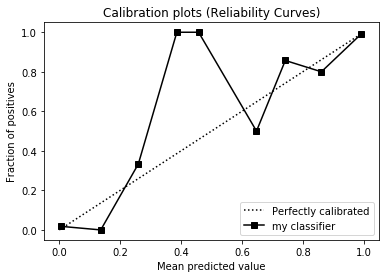

<Figure size 432x288 with 0 Axes>

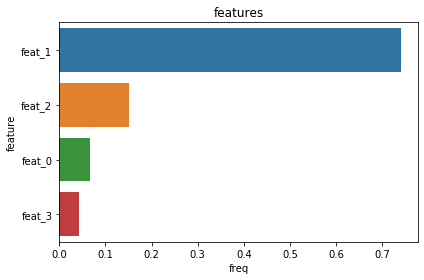

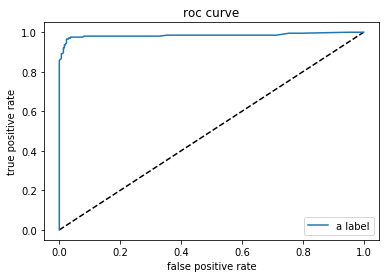

In [32]:
from mlrun import run_local, NewTask, mlconf

run = run_local(NewTask(**task_params),
                handler=xgb_test,
                inputs={"test_set"      : f"{TEST_REPO}/{DATA_PATH}",
                        "models_path"   : f"{TEST_REPO}/{MODELS_PATH}"},
                workdir=mlconf.artifact_path)

In [ ]:
fn.deploy(skip_deployed=True, with_mlrun=False)

run = fn.run(
    NewTask(**task_params),
    inputs={"test_set"      : f"{TEST_REPO}/{DATA_PATH}",
            "models_path"   : f"{TEST_REPO}/{MODELS_PATH}"
        },
    workdir=mlconf.artifact_path)